# Исследование объявлений о продаже квартир

Данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно определить рыночную стоимость объектов недвижимости и установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных (например, расстояние до центра, аэропорта, ближайшего парка и водоёма). 

### Откроем файл с данными и изучим общую информацию. 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
df = pd.read_csv(r'C:\Users\Юлия\Desktop\projects\real_estate_data.csv', sep = '\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [41]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

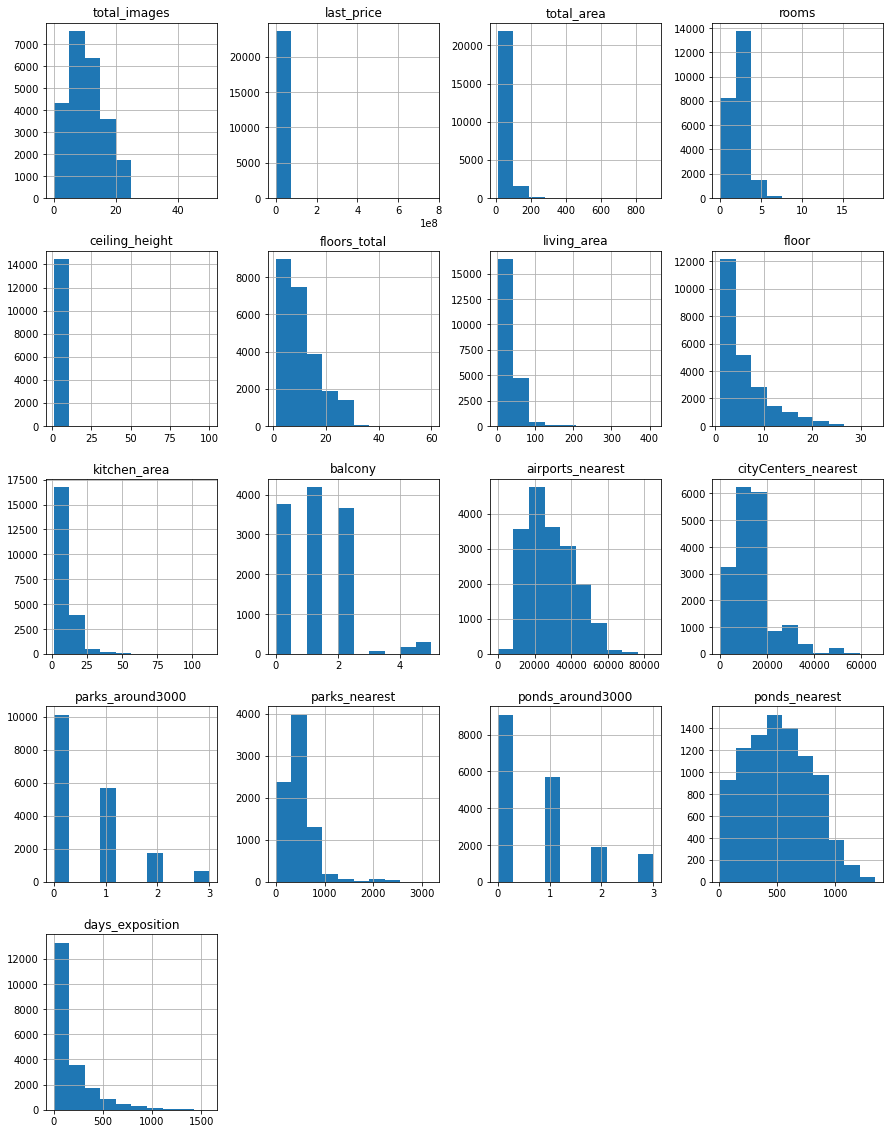

In [43]:
df.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

#### Обработка пропусков

In [44]:
#напишем функцию для просмотра пропущенных значений

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось')

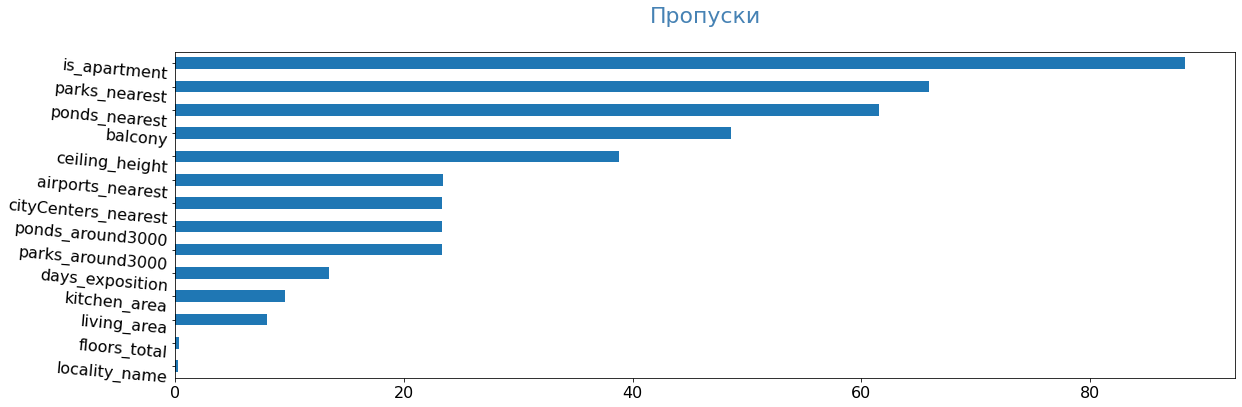

In [45]:
#посмотрим пропущенные значения
pass_value_barh(df)

In [46]:
#создадим новый датафрейм для заполнения пропусков
df2 = df.copy()

##### Обработка пропусков в апартаментах

In [47]:
#возможно, пропущенные значения - это не апартаменты
df2.is_apartment.unique()

array([nan, False, True], dtype=object)

In [48]:
#заменим пропущенные значения на false
df2['is_apartment'] = df2['is_apartment'].fillna(False).astype(bool) 
df2.is_apartment.unique()

array([False,  True])

##### Обработка пропусков количества балконов

In [49]:
#возможно, количество балконов не заполнено, так как балкона нет
df2.balcony.unique() 

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [50]:
#заменим пропущенные значения на 0
df2['balcony'] = df2['balcony'].fillna(0).astype(int) 
df2.balcony.unique()

array([0, 2, 1, 5, 4, 3])

##### Обработка названий населенных пунктов

In [51]:
#посмотрим уникальные названия населенных пунктов
df2['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [52]:
#заполним пропуски по Санкт-Петербургу (ориентируясь на расстояние до центра города) и удалим остальные строки
df2.loc[(df2['cityCenters_nearest'] < 20000) & (df2['locality_name'].isna()), 'locality_name'] = 'Санкт-Петербург'
df2 = df2.dropna(subset=['locality_name']).reset_index()
df2['locality_name'].isna().sum()

0

In [53]:
#напишем функцию по избавлению от неявных дубликатов в названиях населенных пунктов
def rename(ele):
    name = ele.split()
    for i in range(len(name)): 
        if name[i].istitle():
            return name[i]
df2['locality_name_new'] = df2['locality_name'].apply(lambda x: rename(x))
df2['locality_name_new'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое', 'Металлострой',
       'Лебяжье', 'Сиверский', 'Молодцово', 'Кузьмоловский', 'Новая',
       'Павловск', 'Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'Куттузи', 'Аннино', 'Ефимовский',
       'Плодовое', 'Заклинье', 'Торковичи', 'Первомайское', 'Красное',
       'Понтонный', 'Сясьстрой', 'Старая', 'Лесколово', 'Новый', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',
       'Александровская', 'Лопухинка', '

In [54]:
df2['locality_name_new'].nunique()

297

##### Обработка пропусков в общем количестве этажей

In [55]:
#посмотрим уникальные 
df2.floors_total.unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

Проверим теорию, что общее количество этажей пропущено в одноэтажных зданиях

In [56]:
#заполним пропуски и отфильтруем таблицу так, чтобы было видно количество пропусков в floors_total в квартирах на 1 этаже
floors = df2.copy()
floors['floors_total'] = floors['floors_total'].fillna('unknown')
floors = floors[(floors['floor'] == 1) & (floors['floors_total'] == 'unknown')]
floors.pivot_table(index='floors_total',columns='floor', values='rooms', aggfunc='count')

floor,1
floors_total,
unknown,3


Теория не подтвердилась, в одноэтажных зданиях слишком мало пропусков общего количества этажей

In [57]:
#заполним пропуски в floors_total этажом квартиры
for t in df2['floor'].unique():
    df2.loc[(df2['floor'] == t) & (df2['floors_total'].isna()), 'floors_total'] = df2['floor']
df2['floors_total'] = df2['floors_total'].astype(int)
df2['floors_total'].isna().sum()

0

In [58]:
df2['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15,  1, 20, 28, 36, 21, 35, 34, 60, 29, 33,
       52, 37])

In [59]:
#проведем проверку на корректность значений по условию (этажность дома не м.б. ниже этажности квартиры)
df2[df2['floors_total'] < df2['floor']]

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new


##### Обработка пропусков по жилой площади

Проверим гипотезу, что площадь жилого помещения зависит от количества комнат.

0.8459765967817455

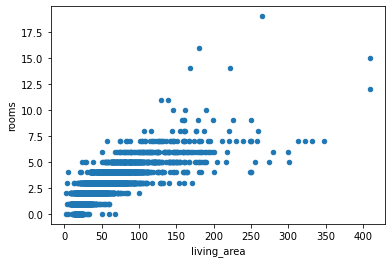

In [60]:
#найдем коэффициент корреляции Пирсона и построим диаграмму рассеивания
display(df2['living_area'].corr(df2['rooms']))
df2.plot(x='living_area', y='rooms', kind='scatter') 
plt.show()

Коэффициент корреляции Пирсона говорит о тесной взаимосвязи количества комнат и жилой площади. 
Из графика также видно, что при увеличении количества комнат, жилая площадь тоже увеличивается. Но все же бывают искючения.

In [61]:
#проверим ошибки в данных где площадь кухни больше общей площади
df2.query('living_area > total_area')

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new


In [62]:
#проверим ошибки в данных где площадь кухни, жилая площадь и 10% площади тех помещений больше общей площади
df2.query('total_area*0.9 <= (living_area + kitchen_area)')['index'].count()

475

In [63]:
#заполним пропуски в жилых помещениях медианным значением в соответствии с количеством комнат
for r in df2['rooms'].unique():
    df2.loc[(df2['rooms'] == r) & (df2['living_area'].isna()) & \
    (df2['total_area']*0.9 <= (df2['living_area'] + df2['kitchen_area'])), 'living_area'] = \
    df2.loc[(df2['rooms'] == r), 'living_area'].median()
df2['living_area'].isna().sum()

1900

Пропущенные значения в жилой площади можно найти как разницу между общей плащадью помещения и площадью кухни (учитывая погрешность по площади тех помещений, санузла, коридора и тд)

In [64]:
#заполним ошибки и пропущенные значения - как общая территория минус территория кухни и тех помещения
df2.loc[(df2['living_area'].isna() & (df2['total_area']*0.8) - df2['kitchen_area']), 'living_area'] = \
(df2['total_area']*0.8) - df2['kitchen_area']
display(df2['living_area'].isna().sum())

1462

In [65]:
#посчитаем средний % сколько занимает жилая территория
print(round((df2['living_area']/df2['total_area']*100).median()), '%')

57 %


In [66]:
#далее заполним пропуски в жилых помещениях как 57% от общей территории
df2.loc[df2['living_area'].isna(), 'living_area'] = df2['total_area']*0.57
df2['living_area'].isna().sum()

0

In [67]:
#проверим ошибки в данных (за 10% берем коридоры, сан.узлы, балконы)
df2.query('total_area*0.9 <= (living_area + kitchen_area)')['index'].count()

475

В ходе заполнения пропусков количество ошибок в данных, где площадь кухни, жилая площадь и 10% площади тех помещений (коридоры, сан.узлы, балконы) больше общей площади, не изменилось.

##### Обработка пропусков по площади кухни

Проверим теорию, что территория кухни не заполнена в студиях (где комнаты не разделены)

In [68]:
#посчитаем количество пропусков kitchen_area в студиях и нет.
t = df2[df2['studio'] == True]['kitchen_area'].isna().sum()
f = df2[df2['studio'] == False]['kitchen_area'].isna().sum()
print('Пропущенна территория кухни в студиях:', t)
print('Пропущенна территория кухни в квартирах:', f)

if t > f:
        print('Теория подтвердилась, в студиях пропусков больше.')
else:
    print('Теория не подтвердилась, в студиях пропусков гораздо меньше.')

Пропущенна территория кухни в студиях: 149
Пропущенна территория кухни в квартирах: 2126
Теория не подтвердилась, в студиях пропусков гораздо меньше.


Пропущенные значения в площади кухни можно найти как разницу между общей плащадью помещения и площадью жилого помещения (учитывая погрешность по площади тех помещений, санузла, коридора и тд)

In [69]:
#проверим ошибки в данных
df2[df2['total_area'] < df2['living_area']]

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new


In [70]:
#заполним пропущенные значения в площади кухни 
df2.loc[(df2['kitchen_area'].isna()) & ((df2['total_area']*0.8) > df2['living_area']), 'kitchen_area'] = \
(df2['total_area']*0.8) - df2['living_area']
display(df2['kitchen_area'].isna().sum())
df2.loc[:, ['total_area', 'living_area', 'kitchen_area']].head()

64

,total_area,living_area,kitchen_area
0,108.0,51.00,25.00
1,40.4,18.60,11.00
2,56.0,34.30,8.30
3,159.0,90.63,36.57
4,100.0,32.00,41.00


In [71]:
#проверка
df2.query('total_area*0.9 <= (living_area + kitchen_area)')['index'].count()

475

##### Обработка пропусков по высоте потолков в помещениях 

Проверим гипотезу, что высота потолков зависит от населенного пункта. Допустим, что в Санкт-Петербурге высота потолков больше, чем в пригороде.

In [72]:
#найдем медиану высоты потолков в Санкт-Петербурге
print('Медиана высоты потолков в Санкт-Петербурге',df2[df2['locality_name_new'] == 'Санкт-Петербург']['ceiling_height'].median())
#найдем общую медиану высоты потолков
height_med = df2['ceiling_height'].median()
print('Общая медиана высоты потолков',height_med)
#построим сводную таблицу и отсортируем значения высоты потолков по убыванию
display(df2.pivot_table(index='locality_name_new', values='ceiling_height', aggfunc='median') \
.reset_index().sort_values(by='ceiling_height', ascending=False).head(20))

Медиана высоты потолков в Санкт-Петербурге 2.7
Общая медиана высоты потолков 2.65


,locality_name_new,ceiling_height
121,Нижняя,27.000
112,Мины,27.000
7,Бокситогорск,3.900
173,Ропша,3.200
14,Ваганово,3.150
35,Глинка,3.100
203,Счастье,3.000
61,Каськово,3.000
10,Бор,2.950
99,Лисий,2.850


Видно,что медиана в Санкт-Петербурге практически не отличается от общей медианы. Также в данных много выросов, по такой таблице оценить данные сложно. Углубимся в исследование.

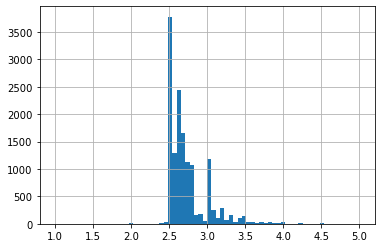

In [73]:
#построим гистограмму, чтобы понять какая высота потолков встречается чаще
df['ceiling_height'].hist(bins=70, range=(1, 5))
plt.show()

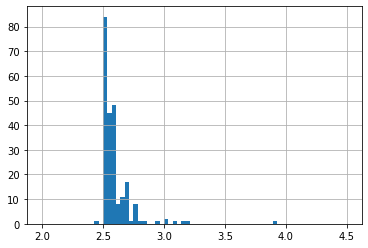

In [74]:
#создадим переменную, где найдем медианное значение высоты потолка по населенному пункту
height_pivot = df2.pivot_table(index='locality_name_new', values='ceiling_height', aggfunc='median') \
.reset_index()
#построим гистограмму,как часто в наборе данных встречается высота потолка в среднем по населенным пунктам.
height_pivot['ceiling_height'].hist(bins=70, range=(2, 4.5))
plt.show()

Из полученных данных, можно наблюдать, что наиболее часто встречающаяся высота потолков (2.5 - 2.7 м) соотносится с общим медианным значением. Учитывая то, что и в поселках, и в городе может быть как старый жилой фонд, так и новый, с разной высотой потолка, можно сделать вывод, что следует заменить пропуски высоты потолка медианным значением в зависимоости от расстояния до центра, т.к. в исторических зданиях высота потолка будет выше, чем в новых районах.

In [75]:
df2['ceiling_height'].describe()

count    14501.000000
mean         2.771517
std          1.261185
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [76]:
#переведем расстояние до центра города в километры 
df2['cityCenters_nearest'] = abs((df2['cityCenters_nearest']/1000).round())
#проверим нет ли отрицательных значений
df2[df2['cityCenters_nearest_km'] < 0]

KeyError: 'cityCenters_nearest_km'

In [ ]:
#посмотрим на взаимосвязь высоты потолков и расстояния до центра города
df2.pivot_table(index = 'cityCenters_nearest', values = 'ceiling_height').plot(figsize = (15,3))
plt.ylim(2,4);

Чтобы учесть отличительное свойство объектов недвижимости в разных районах Питера, заполним пропуски высоты потолков медианным  значением в зависимости от расстояния до центра города.

In [ ]:
#заполним пропуски 
df2['ceiling_height']  = df2['ceiling_height'].fillna(df2.groupby([
    'cityCenters_nearest'])['ceiling_height'].transform(np.median))

(2.0, 4.0)

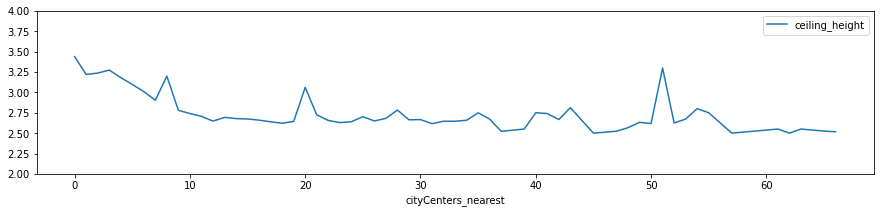

In [77]:
#посмотрим есть ли сильные изменения на графике
df2.pivot_table(index = 'cityCenters_nearest', values = 'ceiling_height').plot(figsize = (15,3))
plt.ylim(2,4)

In [78]:
#посмотрим остались ли пропуски
df2['ceiling_height'].isna().sum()

9186

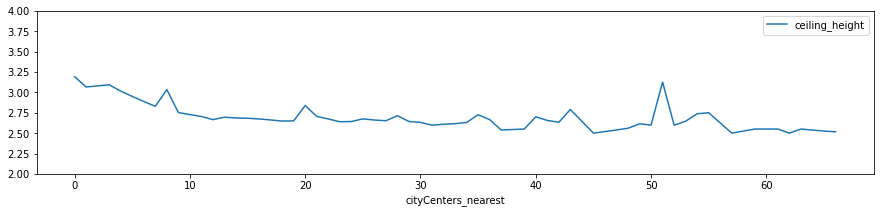

In [79]:
#заполним осташиеся пропуски медианным значением в соответствии с населенным пунктом
df2['ceiling_height']  = df2['ceiling_height'].fillna(df2.groupby([
    'locality_name'])['ceiling_height'].transform(np.median))
#посмотрим изменения на графике
df2.pivot_table(index = 'cityCenters_nearest', values = 'ceiling_height').plot(figsize = (15,3))
plt.ylim(2,4);

In [80]:
df2['ceiling_height'].describe()

count    23566.000000
mean         2.734070
std          1.012229
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [81]:
#проверим, что все пропуски заполнены
df2['ceiling_height'].isna().sum()

121

In [82]:
#заполним оставшиеся пропуски общей медианой
df2.loc[df2['ceiling_height'].isna(), 'ceiling_height'] = height_med
df2['ceiling_height'].isna().sum()

0

##### Обработка столбцов с датами

In [83]:
#изменим тип данных в столце с датой публикации
df2['first_day_exposition'] = pd.to_datetime(df2['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df2['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

In [84]:
#посмотрим за какой период выгружены данные
print(df2['first_day_exposition'].min())
print(df2['first_day_exposition'].max())

2014-11-27 00:00:00
2019-05-03 00:00:00


Предполагаю, что что если в столбце days_exposition пропуск, это означает, что объявление не снято и является актуальным (тк в столбце дни с публикации до снятия). Соответственно, объявление какое-то количество дней размещено, и заменять на 0 дней некорректно. Но чтобы сделать тип int в столбце, необходимо заполнить пропуски. Поэтому, заменим пропуски на -1.

In [85]:
#заменим пропущенные значения на false
df2['days_exposition'] = df2['days_exposition'].fillna(-1).astype(int) 
df2.days_exposition.unique()

array([  -1,   81,  558, ..., 1360, 1007,  971])

##### Обработка пропусков по расстоянию до центра

In [86]:
#cоздадим список населенных пунктов, где отсутствуют данные в столбцe
list_cities_NaN = df2.query('cityCenters_nearest.isna()')['locality_name_new'].unique()
print('Населенные пункты с пропусками', list_cities_NaN)

Населенные пункты с пропусками ['Янино-1' 'Мурино' 'Сертолово' 'Кудрово' 'Коммунар' 'Красный' 'Гатчина'
 'Фёдоровское' 'Выборг' 'Кировск' 'Новое' 'Санкт-Петербург' 'Лебяжье'
 'Сиверский' 'Молодцово' 'Кузьмоловский' 'Новая' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Куттузи' 'Аннино' 'Ефимовский'
 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское' 'Сясьстрой' 'Старая'
 'Лесколово' 'Новый' 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург'
 'Никольское' 'Сосновый' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино'
 'Кириши' 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Шушары' 'Тосно' 'Бокситогорск'
 'Лопухинка' 'Пикалёво' 'Терволово' 'Советский' 'Подпорожье' 'Петровское'
 'Токсово' 'Сельцо' 'Вырица' 'Кипень' 'Келози' 'Вартемяги' 'Тельмана'
 'Севастьяново' 'Большая' 'Агалатово' 'Новогорелово' 'Лесогорский'
 'Лаголово' 'Цвелодубово' 'Рахья' 'Белогорка' 'Заводской' 'Новоселье'
 'Большие' 'Горбунки' 'Батово' 'Заневка' 'Иссад' 'Прим

In [87]:
#посмотрим среднюю удаленность от центра по населенным пунктам
df2.pivot_table(index='locality_name_new', values='cityCenters_nearest', aggfunc='median') \
.reset_index().sort_values(by='cityCenters_nearest')

,locality_name_new,cityCenters_nearest
20,Санкт-Петербург,12.0
13,Парголово,19.0
11,Мурино,22.0
23,Стрельна,24.0
25,Шушары,24.0
14,Песочный,26.0
6,Левашово,26.0
16,Петро-Славянка,27.0
0,Александровская,27.5
9,Металлострой,28.0


На расстояние до центра влияет местонахождение объекта, как в Санкт-Петербурге расстояние может очень отличаться, в зависимости от того, в центре расположен объект или на окраине, так и в поселках, к примеру, если построен новый жк комплекс. Полагаю, что лучше оставить пропуски незаполненными.

##### Обработка пропусков по расстоянию до аэропорта

In [88]:
#заполним пропуски по расстоянию до аэропорта кроме Санкт-Петербурга, тк в Питере может быть слишком большой разброс значений
for loc in df2['locality_name_new'].unique():
    df2.loc[(df2['locality_name_new'] != 'Санкт-Петербург') & (df2['airports_nearest'].isna()), 'airports_nearest'] = \
    df2.loc[(df2['locality_name_new'] == loc), 'airports_nearest'].median()
df2['airports_nearest'].isna().sum()

85

##### Обработка пропусков по числу парков и водоемов и расстояния до них

Предполагаю, что пропуски в столбцах parks_around3000 и ponds_around3000 могут свидетельствовать об отсутствии парка рядом.

In [89]:
#посмотрим уникальные значения по наличию парков
df2.parks_around3000.unique()

array([ 1.,  0.,  2., nan,  3.])

In [90]:
#заменим пропущенные значения на 0
df2['parks_around3000'] = df2['parks_around3000'].fillna(0).astype(int) 
df2.parks_around3000.unique()

array([1, 0, 2, 3])

In [91]:
#посмотрим уникальные значения по наличию водоемов
df2.ponds_around3000.unique()

array([ 2.,  0.,  3.,  1., nan])

In [92]:
#заменим пропущенные значения на 0
df2['ponds_around3000'] = df2['ponds_around3000'].fillna(0).astype(int) 
df2.ponds_around3000.unique()

array([2, 0, 3, 1])

-0.25951357861109475

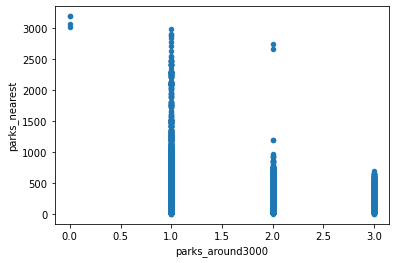

In [93]:
#найдем коэффициент корреляции Пирсона и построим диаграмму рассеивания по наличию паков и расстоянием до них
display(df2['parks_around3000'].corr(df2['parks_nearest']))
df2.plot(x='parks_around3000', y='parks_nearest', kind='scatter')
plt.show()

-0.3418052766890603

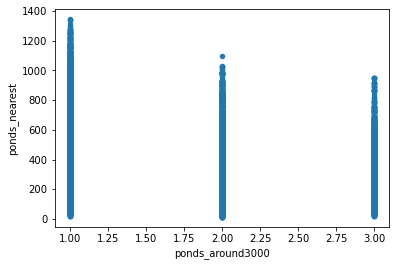

In [94]:
#найдем коэффициент корреляции Пирсона и построим диаграмму рассеивания по наличию водоемов и расстоянием до них
display(df2['ponds_around3000'].corr(df2['ponds_nearest']))
df2.plot(x='ponds_around3000', y='ponds_nearest', kind='scatter') 
plt.show()

Исходя из коэффициентов корреляции и диаграмм рассеивания в разрезе парков и водоемов и расстоянием до них прямой взаимосвязи между ними нет. Целесообразно не заполнять пропуски по расстоянию до парков/водоемов, т.к. это может сильно исказить данные.

In [95]:
#итоговая проверка наличия пропусков
df2.isna().sum()

index                       0
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area               64
balcony                     0
locality_name               0
airports_nearest           85
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15608
ponds_around3000            0
ponds_nearest           14578
days_exposition             0
locality_name_new           0
dtype: int64

#### Изменение типов данных

In [96]:
#для лучшего восприятия переведем цену в тысячи и уберем копейки
df2['last_price'] = df2['last_price'] / 1000
df2['last_price'] = df2['last_price'].astype('int')
df2['last_price'].head()

0    13000
1     3350
2     5196
3    64900
4    10000
Name: last_price, dtype: int32

In [97]:
#округлим до 2 знаков после запятой
list_column = ['total_area', 'ceiling_height', 'living_area', 'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']

for column in list_column:
    if column in df2[column]:
        df2[column].round(2)
df2.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
0,0,20,13000,108.0,2019-03-07,3,2.70,16,51.00,8,...,0,Санкт-Петербург,18863.0,16.0,1,482.0,2,755.0,-1,Санкт-Петербург
1,1,7,3350,40.4,2018-12-04,1,2.63,11,18.60,1,...,2,посёлок Шушары,12817.0,19.0,0,NaN,0,NaN,81,Шушары
2,2,10,5196,56.0,2015-08-20,2,2.70,5,34.30,4,...,0,Санкт-Петербург,21741.0,14.0,1,90.0,2,574.0,558,Санкт-Петербург
3,3,0,64900,159.0,2015-07-24,3,2.70,14,90.63,9,...,0,Санкт-Петербург,28098.0,7.0,2,84.0,3,234.0,424,Санкт-Петербург
4,4,2,10000,100.0,2018-06-19,2,3.03,14,32.00,13,...,0,Санкт-Петербург,31856.0,8.0,2,112.0,1,48.0,121,Санкт-Петербург


In [98]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23687 entries, 0 to 23686
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 23687 non-null  int64         
 1   total_images          23687 non-null  int64         
 2   last_price            23687 non-null  int32         
 3   total_area            23687 non-null  float64       
 4   first_day_exposition  23687 non-null  datetime64[ns]
 5   rooms                 23687 non-null  int64         
 6   ceiling_height        23687 non-null  float64       
 7   floors_total          23687 non-null  int32         
 8   living_area           23687 non-null  float64       
 9   floor                 23687 non-null  int64         
 10  is_apartment          23687 non-null  bool          
 11  studio                23687 non-null  bool          
 12  open_plan             23687 non-null  bool          
 13  kitchen_area    

**Общий вывод:**
Все необходимые данные заполнены, пропуски удалены, типы данных изменены.

#### Обработка аномалий

In [99]:
#посмотрим минимальные и максимальные значения по всем данным объектов недвижимости
(
    df2[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,687.00","23,687.00","23,687.00","23,687.00","23,687.00","23,687.00","23,623.00","23,687.00","23,687.00"
min,0.00,12.00,1.00,-1.00,12.00,2.00,0.20,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000.00",444.80,154.00,33.00,60.00


In [100]:
#посмотрим значения параметров объектов недвижимости на разных квантилях

(
    df2[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,25.19,2.50,-1.00,"1,000.00",13.00,3.80,1.00,2.00
0.500000,2.00,52.00,2.70,74.00,"4,650.00",30.00,9.40,4.00,9.00
0.900000,3.00,93.50,3.00,426.00,"10,915.60",55.00,16.30,13.00,22.00
0.997600,7.00,309.75,4.40,"1,280.15","82,000.00",187.10,54.10,25.00,27.00


##### Балконы

In [101]:
#рассмотрим аномаии
df2['balcony'].describe()

count    23687.000000
mean         0.591126
std          0.959429
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

(0.0, 6.0)

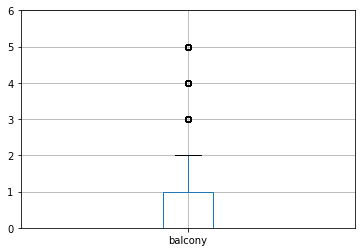

In [102]:
df2.boxplot('balcony')
plt.ylim(0, 6)

Из графика видно, 0, 1 и 2 балкона обычное явление, чего не скажешь о 3, 4 и 5 балконах. Проерим гипотезу, что количество балконов зависит от количества комнат.

-0.015437362160118614

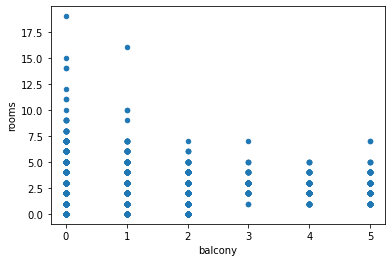

In [103]:
#посмотрим зависимость количества болконов от количества комнат
#найдем коэффициент корреляции Пирсона и построим диаграмму рассеивания
display(df2['balcony'].corr(df2['rooms']))
df2.plot(x='balcony', y='rooms', kind='scatter')
plt.show()

In [104]:
#посчитаем % количества выбросов
display(df2.query('balcony >=3 ')['balcony'].value_counts().sum())
display((df2.query('balcony >= 3')['balcony'].value_counts().sum()) / (df2['balcony'].value_counts().sum()) * 100)

568

2.397939798201545

Из полученных данных можно сказать, что зависимости между количеством балконов и комнат нет. Но следует сохранить данные, тк они не повлияют на дальнейшее исследование, а в других столбцах могут содержаться важные значения.

##### Высота полотков

In [105]:
#рассмотрим аномаии
df2['ceiling_height'].describe()

count    23687.000000
mean         2.733641
std          1.009658
min          1.000000
25%          2.550000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

(0.0, 100.0)

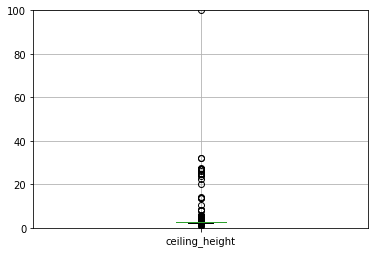

In [106]:
df2.boxplot('ceiling_height')
plt.ylim(0, 100)

Сегодня минимальной нормой в России считается высота потолка 2,4 метра. Для элитного жилья показатель может превышать 3 метра, а также в квартирах, которые относятся к сталинскому ампиру (в некоторых случаях она достигает и 4.5 метров).

In [107]:
#исправим предполагаемые опечатки 
df2.loc[df2['ceiling_height'] >= 24, 'ceiling_height'] = df2['ceiling_height'] / 10
df2['ceiling_height'].sort_values(ascending = False).head(10)

20501    22.60
17492    20.00
15057    14.00
313      13.85
10067    13.85
10065    13.85
22298    10.30
22857    10.00
5862      8.30
15739     8.00
Name: ceiling_height, dtype: float64

In [108]:
#посчитаем % количества выбросов
cel_min = df2.query('ceiling_height < 2.4')['ceiling_height'].value_counts().sum()
cel_max = df2.query('ceiling_height > 6')['ceiling_height'].value_counts().sum()
cel_ful = cel_min + cel_max
display(cel_ful / (df2['ceiling_height'].value_counts().sum()) * 100)

0.1393169248955123

Если удалить часть выбросов, то мы потреляем 0.21% данных. Удаляем выбросы, что меньше минимальной высоты потолка и выше 6м (за 6 метров берем двухэтажные квартиры, иногда в объявлениях пишут общую высоту).

In [109]:
#удаляем аномалии (включая в выборку 2.4 и 6 метровые потолки)
df2 = df2.query('2.4 <= ceiling_height <= 6')

In [110]:
df2['ceiling_height'].describe()

count    23654.000000
mean         2.704216
std          0.225209
min          2.400000
25%          2.550000
50%          2.700000
75%          2.700000
max          6.000000
Name: ceiling_height, dtype: float64

##### Количество дней размещения объявления

In [111]:
#рассмотрим аномаии
df2['days_exposition'].describe()

count    23654.000000
mean       156.555128
std        213.773610
min         -1.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

(-30.0, 1600.0)

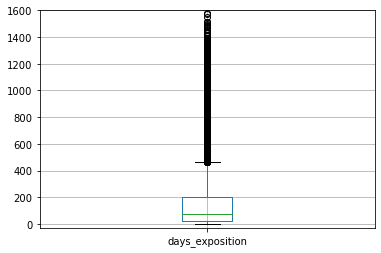

In [112]:
df2.boxplot('days_exposition')
plt.ylim(-30, 1600)

In [113]:
#посчитаем % количества выбросов
display(df2.query('days_exposition > 1100 ')['days_exposition'].value_counts().sum())
display((df2.query('days_exposition > 1100')['days_exposition'].value_counts().sum()) / (df2['days_exposition'].value_counts().sum()) * 100)

163

0.689101209097827

Из диаграммы видно, что большинство объектов продавались меньше, чем за год. Также некоторые объекты продавались больше 3х лет. Пологаю, что лучше удалить объявления старше 3 лет, т.к. они могут повлиять на общую картину

In [114]:
#удаляем аномалии 
df2 = df2.query('days_exposition <= 1100')

In [115]:
#рассмотрим аномаии
df2['days_exposition'].describe()

count    23491.000000
mean       148.966838
std        193.820064
min         -1.000000
25%         22.000000
50%         72.000000
75%        194.000000
max       1100.000000
Name: days_exposition, dtype: float64

##### Этажи

In [116]:
#рассмотрим данные по номеру этажа
df2['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31],
      dtype=int64)

(0.0, 40.0)

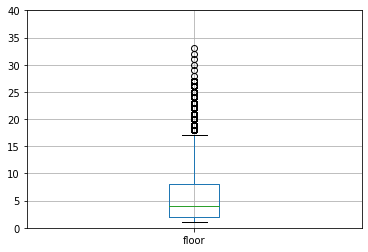

In [117]:
df2.boxplot('floor')
plt.ylim(0, 40)

Критичных выбросов, на мой взляд, нет. Тк есть как многоэтажные здания, так и с малым количеством этажей.

In [118]:
#рассмотрим данные по общему количеству этажей
df2['floors_total'].describe()

count    23491.00000
mean        10.67992
std          6.59700
min          1.00000
25%          5.00000
50%          9.00000
75%         16.00000
max         60.00000
Name: floors_total, dtype: float64

(0.0, 65.0)

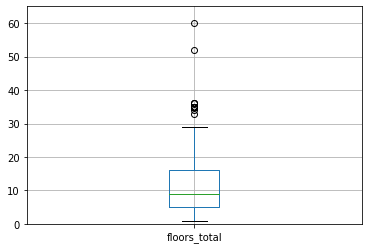

In [119]:
df2.boxplot('floors_total')
plt.ylim(0, 65)

In [120]:
#посчитаем % количества выбросов
display(df2.query('floors_total >=40 ')['floors_total'].value_counts().sum())
display((df2.query('floors_total >= 40')['floors_total'].value_counts().sum()) / (df2['floors_total'].value_counts().sum()) * 100)

2

0.008513898940019582

In [121]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('floors_total < 40')

In [122]:
df2['floors_total'].describe()

count    23489.000000
mean        10.676061
std          6.583908
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

##### Площадь кухни

In [123]:
#рассмотрим аномаии
df2['kitchen_area'].describe()

count    23425.000000
mean        10.751796
std          6.432088
min          0.200000
25%          7.000000
50%          9.340000
75%         12.000000
max        154.000000
Name: kitchen_area, dtype: float64

(0.0, 120.0)

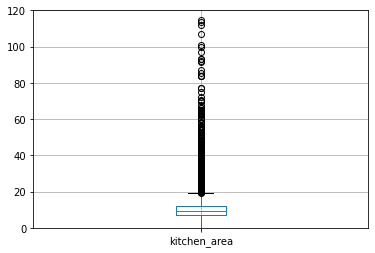

In [124]:
df2.boxplot('kitchen_area')
plt.ylim(0, 120)

Рассмотрим кухни менее 4 м 

In [125]:
#посчитаем % количества выбросов
display(df2.query('kitchen_area < 4')['kitchen_area'].value_counts().sum())
display((df2.query('kitchen_area < 4')['kitchen_area'].value_counts().sum()) / (df2['kitchen_area'].value_counts().sum()) * 100)

249

1.062966915688367

Так как площадь кухни в студиях заполнена медианным значением, для остальных объектов площадь кухни менее 4м аномальо маленькая. Если удалить часть выбросов, то мы потреляем 1% данных.

In [126]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('kitchen_area >= 4')

In [127]:
df2['kitchen_area'].describe()

count    23176.000000
mean        10.841001
std          6.407650
min          4.000000
25%          7.100000
50%          9.400000
75%         12.000000
max        154.000000
Name: kitchen_area, dtype: float64

##### Цена

In [128]:
#рассмотрим аномаии
df2['last_price'].describe()

count     23176.000000
mean       6560.771488
std       10933.379923
min          12.000000
25%        3450.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

(10.0, 770000.0)

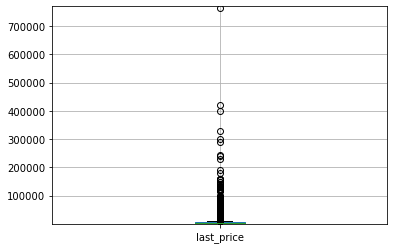

In [129]:
df2.boxplot('last_price')
plt.ylim(10, 770000)

In [130]:
df2.query('last_price < 1000')['last_price'].unique()

array([800, 650, 900, 790, 980, 950, 850, 550, 750, 999, 990, 600, 720,
       500, 700, 770, 710, 760, 450, 820, 490, 780, 777, 970, 585, 690,
       560, 620,  12, 910, 730, 580, 630, 880, 869, 530, 995, 565, 430,
       870, 590, 480, 440, 920, 660, 680, 860, 965, 470, 890, 520, 740,
       799])

In [131]:
#рассмотрим данные по аномальному значению с ценой 12тр
df2.query('last_price == 12')

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new
8792,8793,7,12,109.0,2019-03-20,2,2.75,25,32.0,25,...,0,Санкт-Петербург,36421.0,9.0,1,805.0,0,NaN,8,Санкт-Петербург


Учитывая аномально маленькую цену и короткий срок размещения объявления, скорее всего в цене была допущена ошибка. Полагаю, что данные лучше удалить.

In [132]:
#посчитаем % количества выбросов
pr_min = df2.query('last_price == 12')['last_price'].value_counts().sum()
pr_max = df2.query('last_price > 20000')['last_price'].value_counts().sum()
pr_ful = pr_min + pr_max
display(pr_min / (df2['last_price'].value_counts().sum()) * 100)

0.00431480842250604

Если удалить часть выбросов, то мы потреляем 0.004% данных.

In [133]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('last_price != 12')
df2 = df2.query('last_price <= 20000')

In [134]:
df2['last_price'].describe()

count    22486.000000
mean      5442.308370
std       3216.154052
min        430.000000
25%       3400.000000
50%       4595.000000
75%       6500.000000
max      20000.000000
Name: last_price, dtype: float64

##### Жилая площадь

In [135]:
#рассмотрим аномаии
df2['living_area'].describe()

count    22486.000000
mean        32.676226
std         16.683558
min          2.000000
25%         18.900000
50%         30.000000
75%         41.200000
max        279.600000
Name: living_area, dtype: float64

(0.0, 200.0)

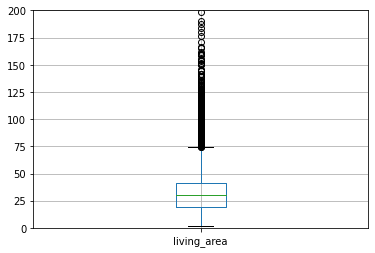

In [136]:
df2.boxplot('living_area')
plt.ylim(0, 200)

In [137]:
#посчитаем % количества выбросов
liv_min = df2.query('living_area < 10')['living_area'].value_counts().sum()
liv_max = df2.query('living_area > 150')['living_area'].value_counts().sum()
liv_ful = liv_min + liv_max
display(liv_ful / (df2['living_area'].value_counts().sum()) * 100)

0.2179133683180646

Если удалить часть выбросов, то мы потреляем 0.2% данных.

In [138]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('living_area >= 10')
df2 = df2.query('living_area <= 150')

In [139]:
df2['living_area'].describe()

count    22437.000000
mean        32.556775
std         16.034603
min         10.000000
25%         18.900000
50%         30.000000
75%         41.100000
max        150.000000
Name: living_area, dtype: float64

##### Общая площадь

In [140]:
#рассмотрим аномаии
df2['total_area'].describe()

count    22437.000000
mean        56.812577
std         23.778192
min         18.000000
25%         40.000000
50%         51.100000
75%         67.200000
max        250.000000
Name: total_area, dtype: float64

(10.0, 270.0)

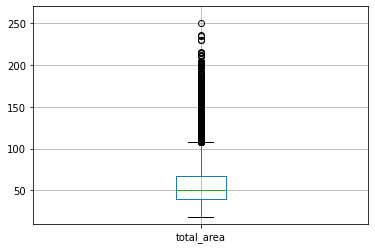

In [141]:
df2.boxplot('total_area')
plt.ylim(10, 270)

In [142]:
#проверим, возможно объекты, площадью меньше 15 м это апартаменты или студии
tot = df2.query('total_area < 15').copy()
display(tot['studio'])
display(tot['is_apartment'])

Series([], Name: studio, dtype: bool)

Series([], Name: is_apartment, dtype: bool)

Из полученных данных можно сказать, что объекты с квадратурой меньше 15м являются аномальными значениями

In [143]:
#посчитаем % количества выбросов
tot_min = df2.query('total_area < 15')['total_area'].value_counts().sum()
tot_max = df2.query('total_area > 200')['total_area'].value_counts().sum()
tot_ful = tot_min + tot_max
display(tot_ful / (df2['total_area'].value_counts().sum()) * 100)

0.08468155279226278

Если удалить часть выбросов, то мы потреляем 0.09% данных.

In [144]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('total_area >= 15')
df2 = df2.query('total_area <= 200')

In [145]:
df2['total_area'].describe()

count    22418.000000
mean        56.678763
std         23.335956
min         18.000000
25%         40.000000
50%         51.000000
75%         67.200000
max        200.000000
Name: total_area, dtype: float64

##### Число фотографий квартиры в объявлении

In [146]:
#рассмотрим аномаии
df2['total_images'].describe()

count    22418.000000
mean         9.824739
std          5.627135
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

(0.0, 51.0)

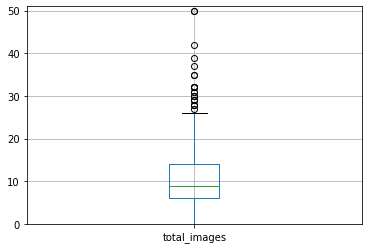

In [147]:
df2.boxplot('total_images')
plt.ylim(0, 51)

In [148]:
#посчитаем % количества выбросов
display(df2.query('total_images >= 30 ')['total_images'].value_counts().sum())
display((df2.query('total_images >= 30')['total_images'].value_counts().sum()) / (df2['total_images'].value_counts().sum()) * 100)

15

0.06691051833348202

Если удалить часть выбросов, то мы потреляем 0.06% данных.

In [149]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('total_images < 30')

In [150]:
df2['total_images'].describe()

count    22403.000000
mean         9.807303
std          5.586011
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         29.000000
Name: total_images, dtype: float64

##### Количество комнат

In [151]:
#рассмотрим аномаии
df2['rooms'].describe()

count    22403.000000
mean         2.016917
std          0.959463
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

(0.0, 12.0)

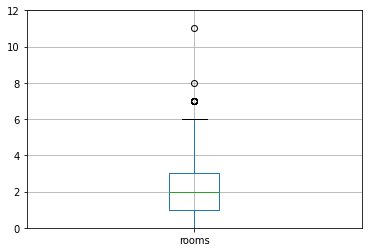

In [152]:
df2.boxplot('rooms')
plt.ylim(0, 12)

In [153]:
#проверим гипотезу, что комнаты с 0 значением либо студии, либо квартиры со свободной планировкой
df2.query('(studio == True or open_plan == True) and rooms == 0')['index'].count()

75

Гипотеза подтвердилась, значения 0 необходимо оставить

In [154]:
#посчитаем % количества выбросов
display(df2.query('rooms > 6 ')['rooms'].value_counts().sum())
display((df2.query('rooms > 6')['rooms'].value_counts().sum()) / (df2['rooms'].value_counts().sum()) * 100)

15

0.0669553184841316

Если удалить часть выбросов, то мы потреляем 0.07% данных.

In [155]:
#удаляем аномалии
df2 = df2.query('rooms <= 6')

In [156]:
df2['rooms'].describe()

count    22388.000000
mean         2.013355
std          0.949500
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

##### Расстояние до аэропорта 

In [157]:
#рассмотрим аномаии
df2['airports_nearest'].describe()

count    22324.000000
mean     28385.075031
std      11225.060548
min          0.000000
25%      20895.000000
50%      26726.000000
75%      34815.000000
max      84853.000000
Name: airports_nearest, dtype: float64

(0.0, 85000.0)

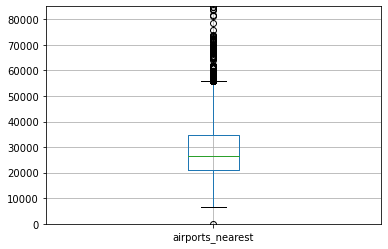

In [158]:
df2.boxplot('airports_nearest')
plt.ylim(0, 85000)

In [159]:
#посчитаем % количества выбросов
air_min = df2.query('airports_nearest < 5000')['airports_nearest'].value_counts().sum()
air_max = df2.query('airports_nearest > 60000')['airports_nearest'].value_counts().sum()
air_ful = air_min + air_max
display(air_ful)
display(air_ful / (df2['airports_nearest'].value_counts().sum()) * 100)

167

0.7480738218957176

Если удалить часть выбросов, то мы потреляем 1% данных.

In [160]:
#удалим некоторые выбросы, чтобы они не искажали дальнейшее исследование
df2 = df2.query('airports_nearest >= 5000')
df2 = df2.query('airports_nearest <= 60000')

In [161]:
df2['airports_nearest'].describe()

count    22157.000000
mean     28097.249583
std      10746.747421
min       6450.000000
25%      20830.000000
50%      26726.000000
75%      34446.000000
max      59705.000000
Name: airports_nearest, dtype: float64

In [162]:
df.shape[0] / df2.shape[0]

1.0695942591506071

**Общий вывод:**
После обработки пропусков и удаления аномальных значений осталось 93,4% исходных данных.

### Посчитаем и добавим в таблицу новые столбцы

In [163]:
#цена одного квадратного метра
df2['price_meter'] = df2['last_price'] / df2['total_area']
df2['price_meter'] = df2['price_meter'].astype('int')
df2.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new,price_meter
0,0,20,13000,108.0,2019-03-07,3,2.70,16,51.0,8,...,Санкт-Петербург,18863.0,16.0,1,482.0,2,755.0,-1,Санкт-Петербург,120
1,1,7,3350,40.4,2018-12-04,1,2.63,11,18.6,1,...,посёлок Шушары,12817.0,19.0,0,NaN,0,NaN,81,Шушары,82
2,2,10,5196,56.0,2015-08-20,2,2.70,5,34.3,4,...,Санкт-Петербург,21741.0,14.0,1,90.0,2,574.0,558,Санкт-Петербург,92
4,4,2,10000,100.0,2018-06-19,2,3.03,14,32.0,13,...,Санкт-Петербург,31856.0,8.0,2,112.0,1,48.0,121,Санкт-Петербург,100
5,5,10,2890,30.4,2018-09-10,1,2.60,12,14.4,5,...,городской посёлок Янино-1,26726.0,NaN,0,NaN,0,NaN,55,Янино-1,95


In [164]:
#день недели публикации объявления
df2['weekday_exposition'] = df2['first_day_exposition'].dt.weekday
#месяц недели публикации объявления
df2['month_exposition'] = df2['first_day_exposition'].dt.month
#год недели публикации объявления
df2['year_exposition'] = df2['first_day_exposition'].dt.year
df2.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_new,price_meter,weekday_exposition,month_exposition,year_exposition
0,0,20,13000,108.0,2019-03-07,3,2.70,16,51.0,8,...,1,482.0,2,755.0,-1,Санкт-Петербург,120,3,3,2019
1,1,7,3350,40.4,2018-12-04,1,2.63,11,18.6,1,...,0,NaN,0,NaN,81,Шушары,82,1,12,2018
2,2,10,5196,56.0,2015-08-20,2,2.70,5,34.3,4,...,1,90.0,2,574.0,558,Санкт-Петербург,92,3,8,2015
4,4,2,10000,100.0,2018-06-19,2,3.03,14,32.0,13,...,2,112.0,1,48.0,121,Санкт-Петербург,100,1,6,2018
5,5,10,2890,30.4,2018-09-10,1,2.60,12,14.4,5,...,0,NaN,0,NaN,55,Янино-1,95,0,9,2018


In [165]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def cat_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df2['cat_floor'] = df2.apply(cat_floor, axis=1)
df2['cat_floor'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

### Проведите исследовательский анализ данных

#### Изучим параметры объектов

count    22157.000000
mean        56.592798
std         23.150066
min         18.000000
25%         40.000000
50%         51.000000
75%         67.100000
max        200.000000
Name: total_area, dtype: float64

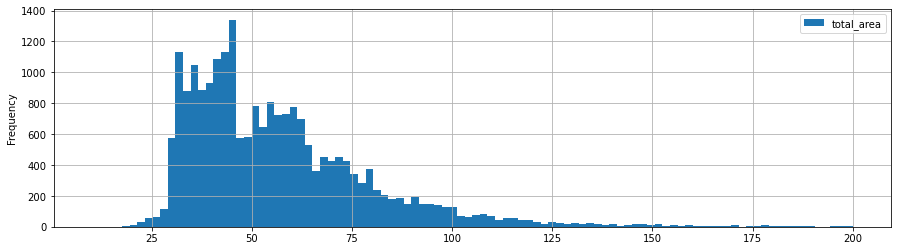

In [168]:
#изучим общую площадь
df2.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (15,4), range = (10,200))
df2['total_area'].describe()

Распределение данных говорит о том, что большинство объектов имеют площадь в диапазоне 39-66 кв м. Есть пик площади около 48 кв м, что свидетельствует о том, что такая квадратура распросранена больше всего. Также можно увидеть, чем больше площадь, тем меньше объявлений.

count    22157.000000
mean        32.421971
std         15.656969
min         10.000000
25%         18.900000
50%         30.000000
75%         41.040000
max        145.400000
Name: living_area, dtype: float64

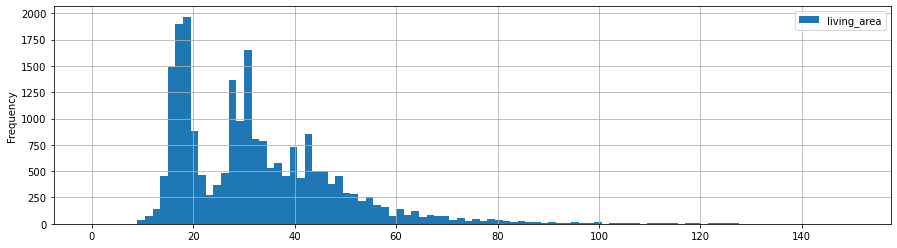

In [169]:
#изучим жилую площадь
df2.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (15,4), range = (0,150))
df2['living_area'].describe()

На гистограмме мы видим два пика в районе 20 и 30 кв м. Это свидетельствует о том, что объекты с данной жилой площадью преобладают в данных. Также можно увидеть, чем больше квадратура жилой площади, тем меньше объявлений.  
Можно предположить, что "провал" в данных жилой площади в районе 21-23 кв м может говорить о том, что объекты с небольшой квадратурой имеют совмещенную жилую зону с кухней, свободные планировки, а также это могут быть студии, что значительно уменьшает квадратуру жилой площади. Объекты, что имеют квадратуру меньше 20 кв м могут быть комнатами.

count    22157.000000
mean        10.280818
std          4.781334
min          4.000000
25%          7.000000
50%          9.200000
75%         12.000000
max         83.900000
Name: kitchen_area, dtype: float64

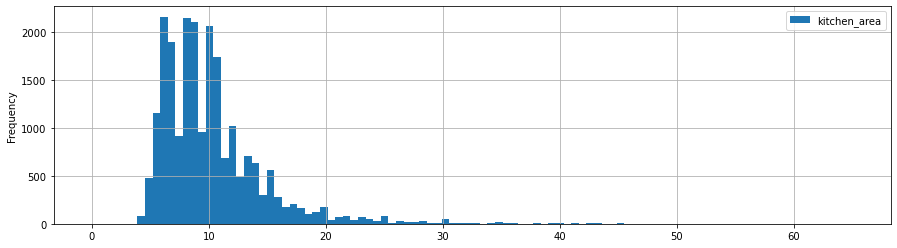

In [170]:
#изучим площадь кухни
df2.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (15,4), range = (0,65))
df2['kitchen_area'].describe()

По распределению данных видно, что большинство объектов имеют небольшую площадь кухни. Большинство объектов имеют площадь кухни в диапазоне 7-11 кв м. Есть пик площади около 9 кв м. 
Гистраграмма соотносится с графиками с общей и жилой площадями, тк все 3 графика говорям о том, что чем больше площадь, тем меньще объявлений.

count    22157.000000
mean      5412.733854
std       3168.304606
min        430.000000
25%       3400.000000
50%       4590.000000
75%       6500.000000
max      20000.000000
Name: last_price, dtype: float64

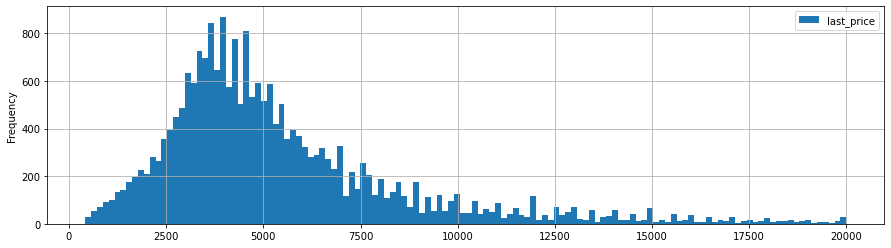

In [171]:
#изучим цену объекта
df2.plot(y = 'last_price', kind = 'hist', bins = 130, grid=True, figsize = (15,4), range = (420,20000))
df2['last_price'].describe()

Распределение данных говорит о том, что в основном цена объектов находится в диапазоне 3.4-6.4 млн руб. Есть пик цены около 4.5 млн руб. Также можно увидеть, что меньше объявлений по высокой цене.

count    22157.000000
mean         2.014803
std          0.949414
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

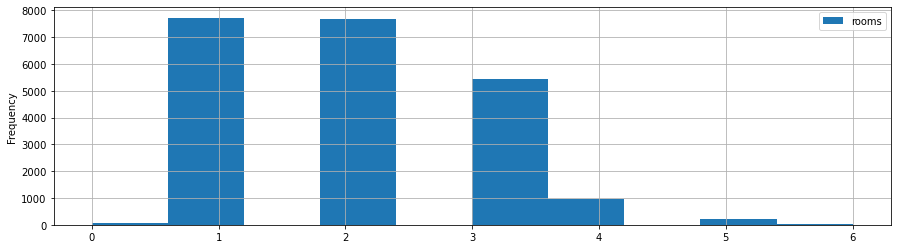

In [172]:
#изучим количество комнат
df2.plot(y = 'rooms', kind = 'hist', bins = 10, grid=True, figsize = (15,4), range = (0,6))
df2['rooms'].describe()

На гистограмме можно увидеть, что большинсво объектов имеют 1-2 комнаты.

count    22157.000000
mean         2.691735
std          0.204755
min          2.400000
25%          2.550000
50%          2.700000
75%          2.700000
max          5.300000
Name: ceiling_height, dtype: float64

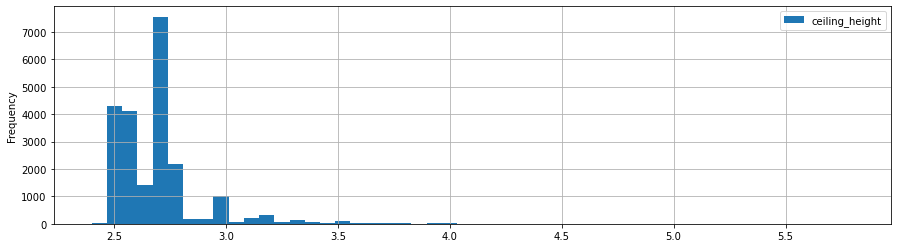

In [173]:
#изучим высоту потолков
df2.plot(y = 'ceiling_height', kind = 'hist', bins = 50, grid=True, figsize = (15,4), range = (2.4,5.8))
df2['ceiling_height'].describe()

На гистограмме можно наблюдать, что объектов с высокими потолками очень мало, в основном преобладают объекты с высотой потолка около 2.7 м

count    22157.000000
mean         5.874848
std          4.870270
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

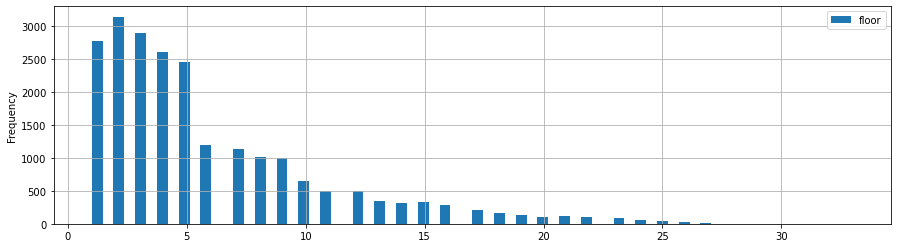

In [174]:
#изучим этаж квартиры
df2.plot(y = 'floor', kind = 'hist', bins = 70, grid=True, figsize = (15,4), range = (1,33))
df2['floor'].describe()

Из графика видно, что основная масса объектов расположена со 1 по 9 этажи, преобладают объекты, находящиеся на 2 этаже

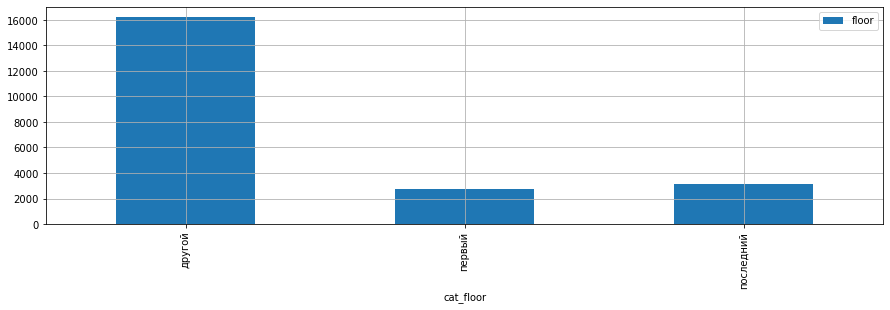

In [175]:
#изучим тип этажа квартиры
df2.pivot_table(index='cat_floor',values='floor', aggfunc='count').plot(kind='bar', grid=True, figsize = (15,4))
plt.show()

По графику можно сделать вывод, лидирующее количество объектов находятся на промежутоных этажах(не первый и не последний). 

count    22157.000000
mean        10.688947
std          6.570071
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

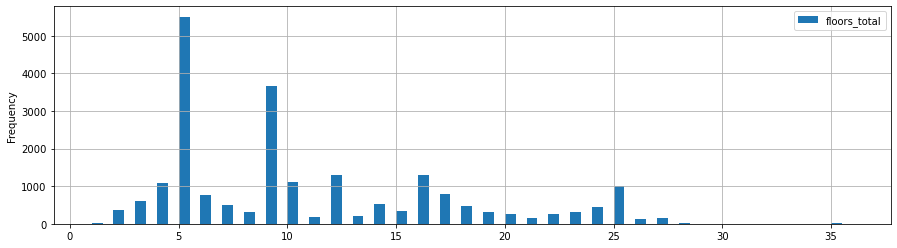

In [176]:
#изучим общее количество этажей в доме
df2.plot(y = 'floors_total', kind = 'hist', bins = 70, grid=True, figsize = (15,4), range = (1,36))
df2['floors_total'].describe()

По постоенной гистраграмме можно сделать вывод, что большинство объектов продаются в 5/9 этажных зданиях

count    16865.000000
mean        14.242870
std          8.009723
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         61.000000
Name: cityCenters_nearest, dtype: float64

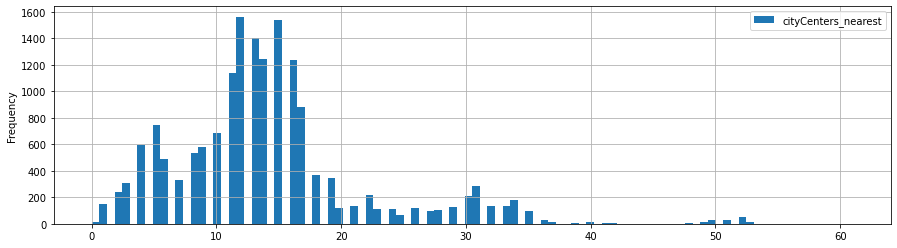

In [203]:
#изучим расстояние до центра города 
df2.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 100, grid=True, figsize = (15,4))
df2['cityCenters_nearest'].describe()

Из гистограммы видно, что основная масса объектов продается в диапазоне 11-15 км от центра города. Большинство продается на расстоянии 12 км от центра. Чем дальше от центра, тем меньше объявлений.

count    22157.000000
mean     28097.249583
std      10746.747421
min       6450.000000
25%      20830.000000
50%      26726.000000
75%      34446.000000
max      59705.000000
Name: airports_nearest, dtype: float64

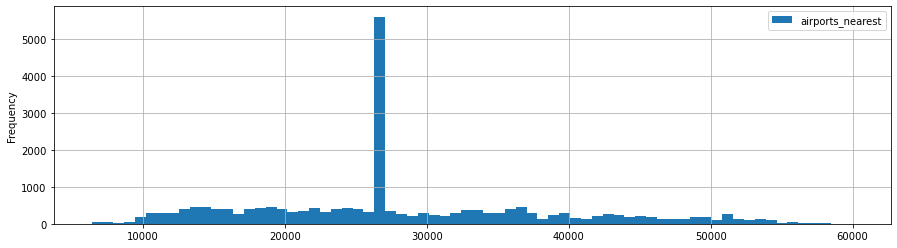

In [178]:
#изучим расстояние до ближайшего аэропорта
df2.plot(y = 'airports_nearest', kind = 'hist', bins = 70, grid=True, figsize = (15,4), range = (6400,60000))
df2['airports_nearest'].describe()

Из гистограммы видно, что основная масса объектов продается на расстоянии 20-35 км от аэропорта. Большинство продается на расстоянии 27 км от аэропорта.

count    7270.000000
mean      495.004677
std       340.476438
min         1.000000
25%       293.000000
50%       458.000000
75%       616.000000
max      3190.000000
Name: parks_nearest, dtype: float64

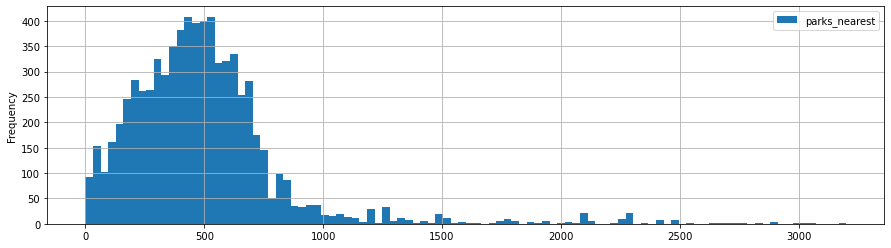

In [179]:
#изучим расстояние до ближайшего парка
df2.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (15,4), range = (0,3200))
df2['parks_nearest'].describe()

Из гистограммы видно, что основная масса объектов продается в районе 300-600 м от ближайшего парка. Самое частое расположение объектов в районе 500 м от парка.

count    22157.000000
mean         2.570249
std          1.791939
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

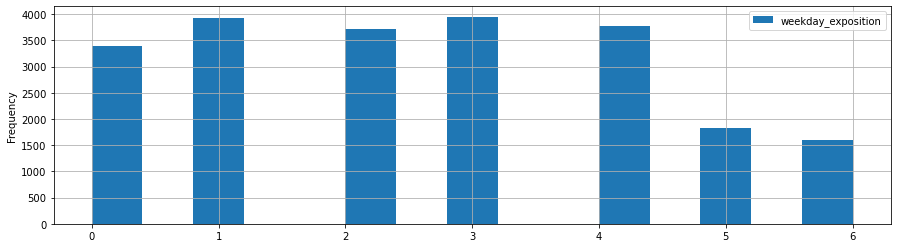

In [180]:
#изучим день публикации объявления
df2.plot(y = 'weekday_exposition', kind = 'hist', bins = 15, grid=True, figsize = (15,4), range = (0,6))
df2['weekday_exposition'].describe()

По представленным данным выше можно сказать, что в выходные объявления публикуются почти в 2 раза меньше

count    22157.000000
mean         6.399242
std          3.485380
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

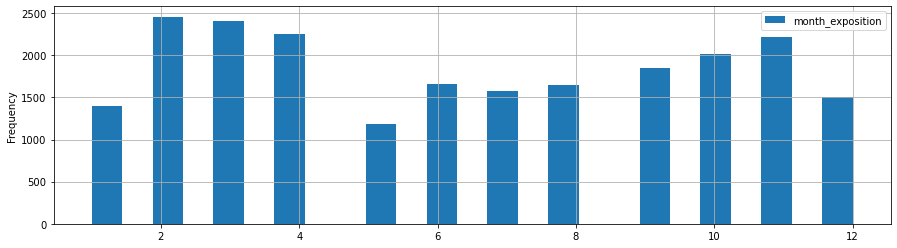

In [181]:
#изучим месяц публикации объявления
df2.plot(y = 'month_exposition', kind = 'hist', bins = 25, grid=True, figsize = (15,4), range = (1,12))
df2['month_exposition'].describe()

Исходя из полученной гистограммы можно увидеть закономерность размещения объявлений. В декабре, январе и мае объявлений размещали гораздо меньше, чем в остальные месяца. Также можно увидеть снижение частоты размещения объявлений к лету и рост к зиме

#### Изучим как быстро продавались квартиры

count    22157.000000
mean       148.330866
std        192.667414
min         -1.000000
25%         23.000000
50%         72.000000
75%        193.000000
max       1100.000000
Name: days_exposition, dtype: float64

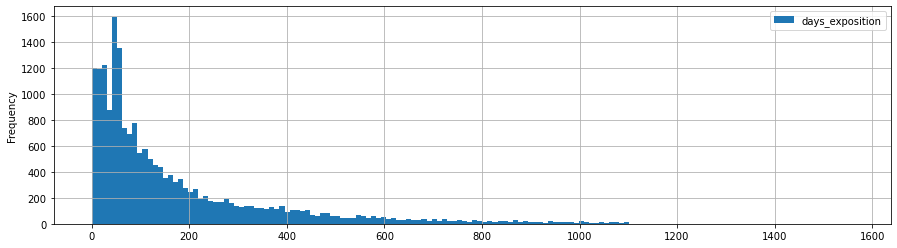

In [182]:
#изучим скорость продажи квартиры
df2.plot(y = 'days_exposition', kind = 'hist', bins = 150, grid=True, figsize = (15,4), range = (0,1560))
df2['days_exposition'].describe()

count    19258.000000
mean       170.810365
std        197.095345
min          1.000000
25%         44.000000
50%         93.000000
75%        222.000000
max       1100.000000
Name: days_exposition, dtype: float64

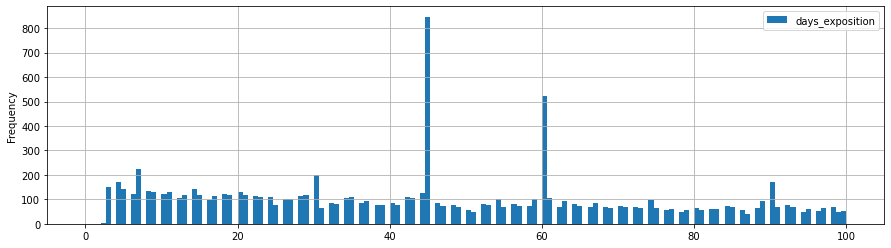

In [183]:
#изучим скорость продажи квартиры, не учитывая актуальные объявления
df2.plot(y = 'days_exposition', kind = 'hist', bins = 150, grid=True, figsize = (15,4), range = (0,100))
#выведем среднее и медиану с помощью describe
df2.query('days_exposition > 0')['days_exposition'].describe()

После исключения актуальных объявлений по среднему и медианому значению можно сказать, что объекты в среднем продавались за пол года. Но если не учитывать слишком долгие прожади, то объекты продавались за 3 месяца. Также проанализировав гистограмму, можно предположить, что выбросы в районе 45 и 60 дней могут говорить о том, что объявления не были продлены автоматически.

(0.0, 1560.0)

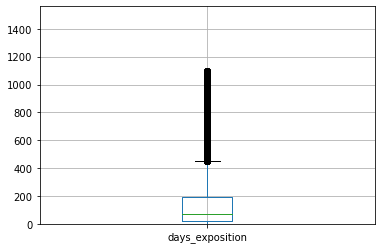

In [184]:
#построим диаграмму размаха, чтобы определить слишком быстрые и необычно долгие продажи
df2.boxplot('days_exposition')
plt.ylim(0, 1560)

Предполагаю, что объявления, снятые с публикации в первом квартиле (44 дня) не совсем корректно считать быстрыми продажами, тк объявление могло быть снято автоматически, поэтому предлагаю считать быстрыми продажами дни до медианного значения (3 месяца).
Все, что находится за пределами "усов" и считается выбросами (больше 450 дней) можно считать необычно долгими продажами.

#### Изучим какие факторы больше всего влияют на общую (полную) стоимость объекта

Коэффициент коррекляции общей площади и цены 0.77


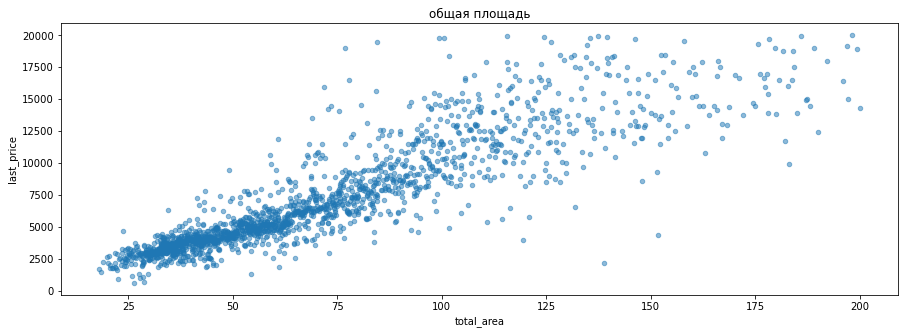

In [185]:
#рассмотрим зависимость общей площади и стоимости объекта
print('Коэффициент коррекляции общей площади и цены', df2['total_area'].corr(df2['last_price']).round(2))
(
    df2.pivot_table(index='total_area',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='total_area', y='last_price', kind='scatter', alpha=0.5, title='общая площадь', figsize = (15,5))
)
plt.show()

'Коэффициент коррекляции жилой площади и цены'

0.66

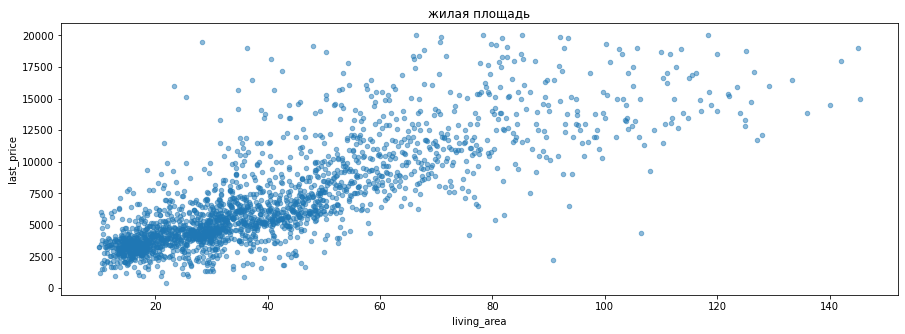

In [186]:
#рассмотрим зависимость жилой площади и стоимости объекта
display('Коэффициент коррекляции жилой площади и цены', df2['living_area'].corr(df2['last_price']).round(2))
(
    df2.pivot_table(index='living_area',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='living_area', y='last_price', kind='scatter', alpha=0.5, title='жилая площадь', figsize = (15,5))
)
plt.show()

Коэффициент коррекляции площади кухни и цены 0.58


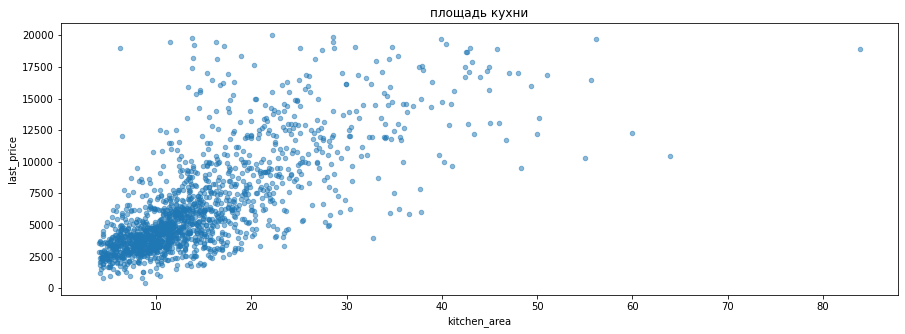

In [187]:
#рассмотрим зависимость площади кухни и стоимости объекта
print('Коэффициент коррекляции площади кухни и цены', df2['kitchen_area'].corr(df2['last_price']).round(2))
(
    df2.pivot_table(index='kitchen_area',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.5, title='площадь кухни', figsize = (15,5))
)
plt.show()

Коэффициент коррекляции нам говорит о тесной взимосвязи между ценой и площадью. Самая сильная взаимосвязь между общей площадью и ценой, тогда как в отношении жилой площади и площади кухни взаимосвязь снижается. На это можгут влиять как свободные планировки, так и студии в исследуемых даных.    
Графикинам говорят, что чем больше площадь, тем выше цена объекта. Но с увеличемием площади объекта связь цены и площади начинает теряться. Из графика по зависимости общей площади и цены можно наблюдать тесную связь до показателя площади около 75 м кв. На это могут влиять другие факторы, как количество комнат, новый/старый жилой фонд, расположение относительно центра и тд. К примеру с квадратурой 100 м может быть как объект с большим количеством комнат, так и однокомнатная квартира в центре города. Соответственно цена таких объектов будет сильно различаться.

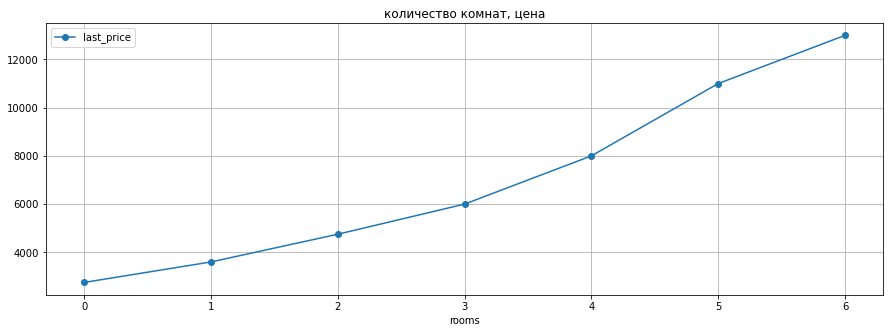

In [188]:
#рассмотрим зависимость количества комнат и стоимости объекта
(
    df2.pivot_table(index='rooms',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='rooms', y='last_price', style='o-', title='количество комнат, цена', figsize = (15,5), grid=True)
)
plt.show()

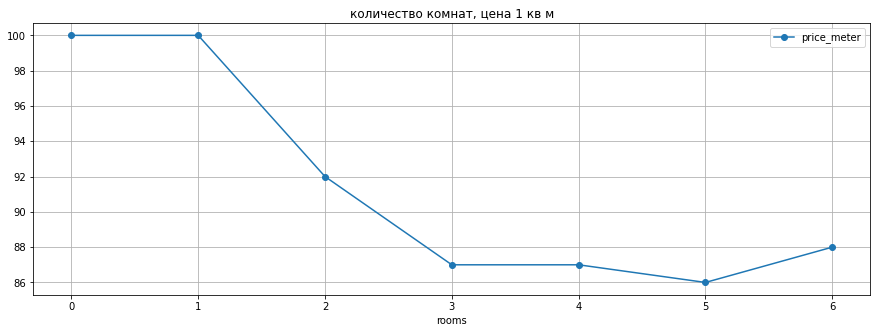

In [189]:
#рассмотрим зависимость количества комнат и стоимости объекта за 1 кв м
(
    df2.pivot_table(index='rooms',values='price_meter', aggfunc='median')
    .reset_index()
    .plot(x='rooms', y='price_meter', style='o-', title='количество комнат, цена 1 кв м', figsize = (15,5), grid=True)
)
plt.show()

Исследовав зависимость цены и количество комнат в объектах можно сделать следующие выводы.    
Если мы не учитываем стоимость 1 кв метра, то видна зависимость - чем больше комнат, тем дороже цена объекта.    
Но если брать в расчет стоимость квадратного метра, то можно увидеть, что самая дорогая цена за кв метр у студий и квартир со свободной планировкой(0 на графике). Далее по цене идут однокомнатные и идет снижение стоимости до 5 комнат. В 6 комнатных квартирах идет рост цены за квадратный метр, тк такие объекты относятся к сегменту премиум.

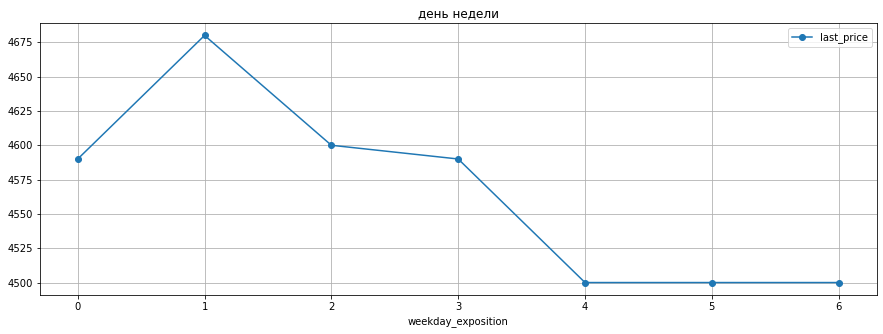

In [190]:
#рассмотрим зависимость дня недели и стоимости объекта
(
    df2.pivot_table(index='weekday_exposition',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='weekday_exposition', y='last_price', style='o-', title='день недели', figsize = (15,5), grid=True)
)
plt.show()

На графике показан рост цены у объявлений, выложенных по вторникам и средам, но это скорее можно отнести к погрешности, т.к. разброс времени слишком большой, чтобы можно было увидеть реальную взаимосвязь.

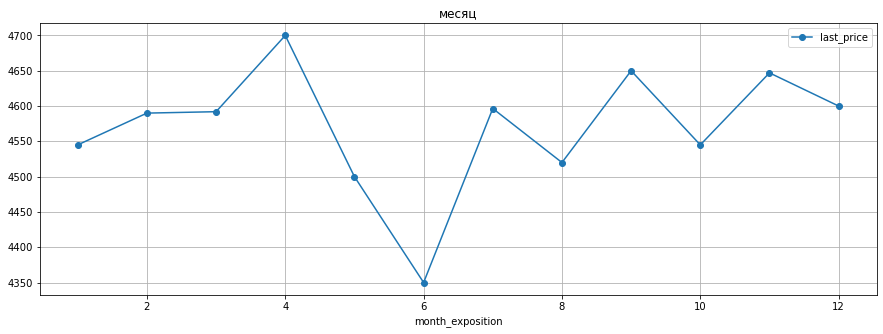

In [191]:
#рассмотрим зависимость месяца и стоимости объекта
(
    df2.pivot_table(index='month_exposition',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='month_exposition', y='last_price', style='o-', title='месяц', figsize = (15,5), grid=True)
)
plt.show()

На графике видна взаимосвязь цены с месяцем публикации обявления. Виден пик роста в апреле и спад к июню. Тк существуют волны спроса на покупку недвижимости, которые зависят в том числе и от наличия свободного времени у людей, и в сезон праздников и отпусков спрос на покупку недвижимости может снижаться.    
Предполагаю, что график отображает взаимосвязь с погрешностью, тк мы смотрим зависимость цены на момент снятия объявления с публикации и месяца на момент публикации объявления. Этот временной лаг может давать погрешность, тк большое количество объявлений были актуальны больше одного месяца.

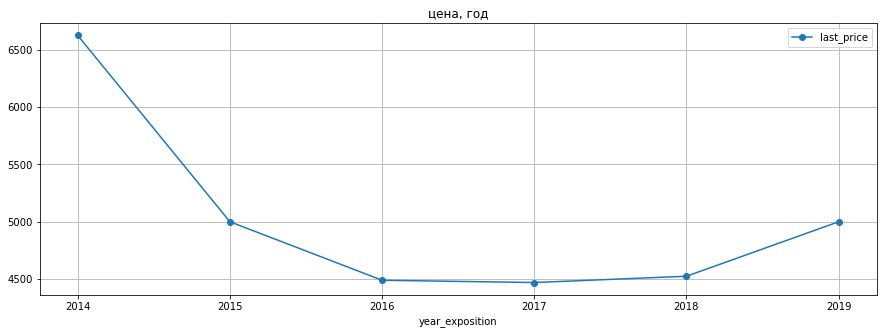

In [192]:
#рассмотрим зависимость года и стоимости объекта
(
    df2.pivot_table(index='year_exposition',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='year_exposition', y='last_price', style='o-', title='цена, год', figsize = (15,5), grid=True)
)
plt.show()

График показывает небольшое снижение стоимости с 2015 года и небольшой рост с 2017 года. 2014 год мы не берем в расчет из-за неполноты данных за данный период.

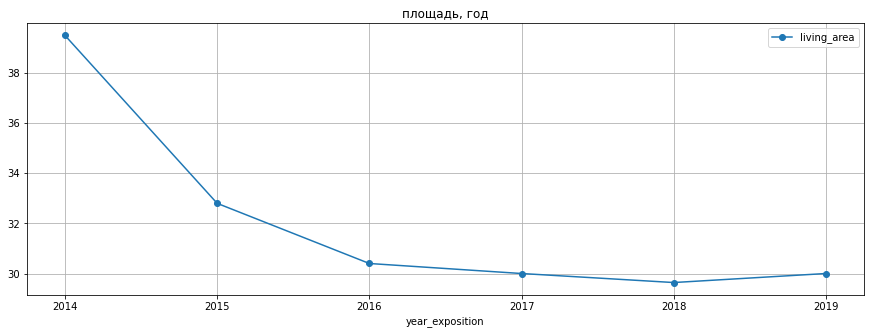

In [193]:
#рассмотрим зависимость года и средней площади продаваемых квартир
(
    df2.pivot_table(index='year_exposition',values='living_area', aggfunc='median')
    .reset_index()
    .plot(x='year_exposition', y='living_area', style='o-', title='площадь, год', figsize = (15,5), grid=True)
)
plt.show()

Из графика взаимосвязи площади продаваемых объектов и цены, можно заметить, что площадь снижалась равносильно цене. Из этого можно сделать вывод, что на снижение цены продаваемых объектов повлияла площадь.

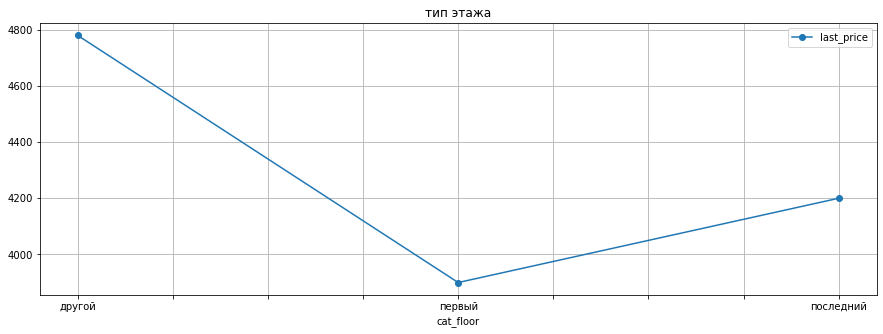

In [194]:
#изучим тип этажа квартиры
(
    df2.pivot_table(index='cat_floor',values='last_price', aggfunc='median')
    .reset_index()
    .plot(x='cat_floor', y='last_price', style='o-', title='тип этажа', figsize = (15,5), grid=True)
)
plt.show()

Из графика понятно, что объекты на первом и последнем этажах стоят гораздо дешевле остальных. Объекты на первом этаже самые дешевые.

**Общий вывод:**
можно сказать, что факторы, которые больше всего влияют на общую стоимость объекта это общая площадь объекта, количество комнат, тип этажа и временной промежуток (год, сезон).

#### Найдем населённые пункты с самой высокой и низкой стоимостью квадратного метра

In [195]:
locality_m_pivot = df2.pivot_table(index = 'locality_name', values = 'price_meter', aggfunc=['mean', 'count'])
locality_m_pivot.columns = ['mean', 'count']
locality_m_pivot = locality_m_pivot.sort_values('count', ascending = False).reset_index().round(2).head(10)
locality_m_pivot_max = locality_m_pivot[locality_m_pivot['mean']==locality_m_pivot['mean'].max()].reset_index()
display('Самая высокая стоимость 1 кв м в городе:', locality_m_pivot_max)

locality_m_pivot_min = locality_m_pivot[locality_m_pivot['mean']==locality_m_pivot['mean'].min()].reset_index()
display('Самая высокая стоимость 1 кв м в городе:', locality_m_pivot_min)

display(locality_m_pivot.sort_values('count', ascending = False).reset_index().round(2).head(10))

'Самая высокая стоимость 1 кв м в городе:'

,index,locality_name,mean,count
0,0,Санкт-Петербург,107.9,14611


'Самая высокая стоимость 1 кв м в городе:'

,index,locality_name,mean,count
0,9,Выборг,57.78,235


,index,locality_name,mean,count
0,0,Санкт-Петербург,107.90,14611
1,1,посёлок Мурино,84.57,481
2,2,посёлок Шушары,77.66,432
3,3,Всеволожск,66.89,387
4,4,Пушкин,101.38,353
5,5,Колпино,74.75,335
6,6,Гатчина,68.26,307
7,7,посёлок Парголово,92.26,292
8,8,деревня Кудрово,91.36,272
9,9,Выборг,57.78,235


Cамая высокая стоимость жилья за 1 квадратный метр из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Выборге.

#### Вычислим среднюю цену каждого километра в Санкт-Петербурге 

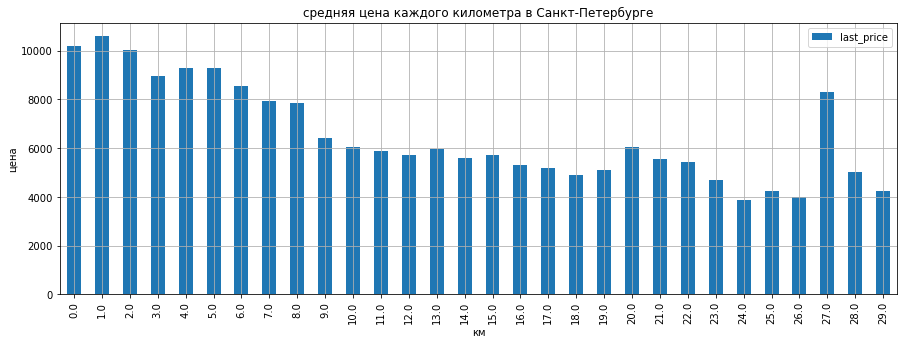

In [198]:
(
    df2.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index = 'cityCenters_nearest', values = 'last_price', aggfunc = 'mean')
    .reset_index()
    .plot(x='cityCenters_nearest', y='last_price', kind='bar',style='o-', \
          title='средняя цена каждого километра в Санкт-Петербурге', figsize = (15,5), grid=True, xlabel='км', ylabel='цена')
)
plt.show()

Стоимость объектов напрямую зависит от расстояния до центра города. Чем дальше от центра, тем ниже цена. В районе 27 километров от центра мы видим пик цены, объекты там дороже, чем в центре. Предполагаю, что это может быть обусловлено элитным и дорогим районом, где стоимость гораздо выше.

Посмотрим на категории квартир, которые продаются на каждом километре в Санкт-Петербурге

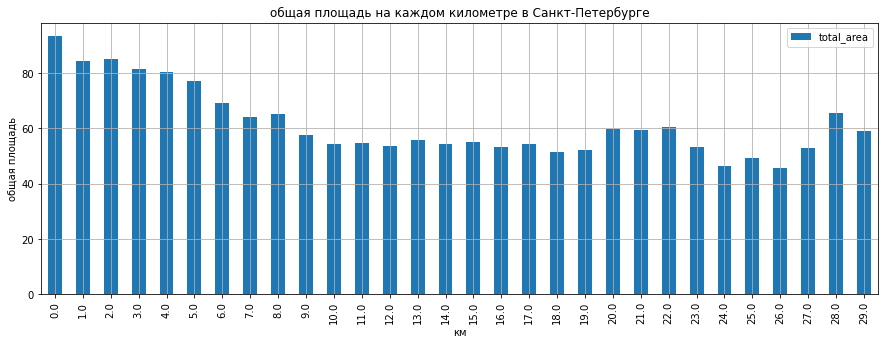

In [199]:
(
    df2.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index = 'cityCenters_nearest', values = 'total_area', aggfunc = 'mean')
    .reset_index()
    .plot(x='cityCenters_nearest', y='total_area', kind='bar',style='o-', \
          title='общая площадь на каждом километре в Санкт-Петербурге', \
          figsize = (15,5), grid=True, xlabel='км', ylabel='общая площадь')
)
plt.show()

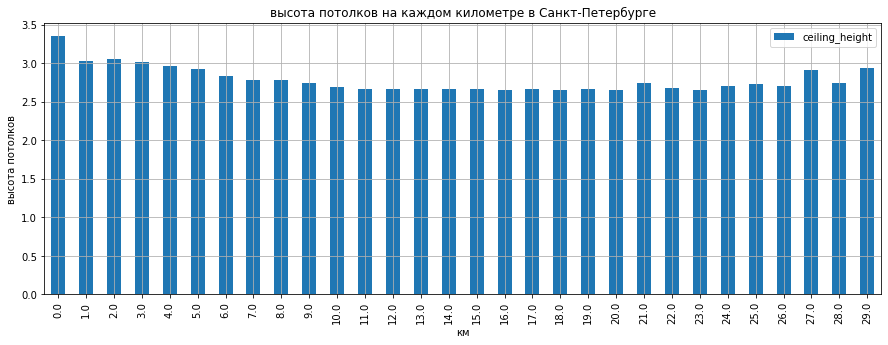

In [200]:
(
    df2.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index = 'cityCenters_nearest', values = 'ceiling_height', aggfunc = 'mean')
    .reset_index()
    .plot(x='cityCenters_nearest', y='ceiling_height', kind='bar',style='o-', \
          title='высота потолков на каждом километре в Санкт-Петербурге', \
          figsize = (15,5), grid=True, xlabel='км', ylabel='высота потолков')
)
plt.show()

Из проведенного исследования можно заметить, что в центре  и начиная с 27 км площадь и высота потолков продаваемых объектов гораздо выше. Предполагаю, что от высоты потолков и общей площади объекта зависит класс жилья и, соответсвенно, уровень цены. Поэтому мы можем наблюдать высокий уровень цены в центре и на 27 км.

### Общий вывод

Были исследованы данные сервиса Яндекс.Недвижимость о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.    

В ходе предобработки имеющихся данных:
- откорректированы данные в разрезе заполнения пропушенных значений, где это было возможно;
- удалены дубликаты и скорректированы названия населенных пунктов; 
- изменены типы данных, где это было необходимо;
- посчитана и добавлена в таблицу цена квадратного метра жилья;
- добавлены день недели, месяц и год размещения объявления;
- определены и добавлены категории этажей квартир;
- удалены выбивающиеся значения (аномально большие или маленькие);
- подтверждена гипотеза, что комнаты со значением 0 это либо студии, либо квартиры со свободной планировкой.    

Во время исследовательского анализа данных было выяснено:    

- большинство объектов имеют площадь в диапазоне 39-66 кв м, с большой площадью объялений меньше;
- большинство объектов имеют небольшую площадь кухни;
- в основном цена объектов находится в диапазоне 3.4-6.4 млн руб., по высокой цене объявлений меньше;
- большинсво объектов имеют 1-2 комнаты, преобладают объекты на 2 этаже, на 1 и последнем этажах объектов значительно меньше;
- в основном объекты продаются в 5 и 9 этажных зданиях в районе 11-15 км от центра города, 20-35 км от аэропорта и 300-600 м от ближайшего парка;
- чем дальше от центра, тем меньше объявлений;
- в выходные публикуются почти в 2 раза меньше объявлений, а также в декабре, январе и мае объявления размещали гораздо реже, чем в остальные месяца(снижение частоты размещения объявлений к лету и рост к зиме);
- быстрые продажи объектов - 3 месяца, а все что больше 450 дней можно считать необычно долгими продажами.    

При изучении факторов, которые больше всего влияют на общую (полную) стоимость объекта было определено:
- чем больше площадь, тем выше цена объекта, но с увеличемием площади объекта связь цены и площади теряется.
- чем больше комнат, тем дороже цена объекта. Но если брать в расчет стоимость квадратного метра, то самая дорогая цена за кв метр у студий и квартир со свободной планировкой, далее по цене идут однокомнатные и идет снижение стоимости до 5 комнат. В 6 комнатных квартирах идет рост цены за квадратный метр;
- взаимосвязь цены с месяцем публикации обявления есть, но, для того чтобы определить ее более точно необходимо дополнительные даные (дата снятия объявления, либо начальная цена);
- есть небольшое снижение стоимости объектов с 2015 года и небольшой рост с 2017 года;
- объекты на первом и последнем этажах стоят гораздо дешевле остальных, на первом этаже самые дешевые;
- самая высокая стоимость жилья за 1 квадратный метр из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге (108 тр), самая низкая стоимость в Выборге (58 тр);
- чем дальше от центра, тем ниже цена. В районе 27 километров от центра пик цены. В центре и начиная с 27 км площадь и высота потолков продаваемых объектов гораздо выше.